# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from obp.policy import QLearner
from sklearn.ensemble import GradientBoostingRegressor

from cate.dataset import Dataset, to_rank
from cate.utils import PathLinker, Timer, get_logger

/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pathlinker = PathLinker().data.criteo
timer = Timer()
logger = get_logger("obp")

# Functions

# Read Data

In [3]:
ds = Dataset.load(pathlinker.base)

# Model

In [4]:
base_regressor = GradientBoostingRegressor()
models = {"qlearner": QLearner(n_actions=2, base_model=base_regressor)}

In [32]:
pred_dfs = {}
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, model in models.items():
    _pred_dfs = []
    logger.info(f"start {name}")
    for i, (train_idx, valid_idx) in tqdm(
        enumerate(skf.split(np.zeros(len(ds)), ds.y))
    ):
        train_X = ds.X.iloc[train_idx].to_numpy()
        train_y = ds.y.iloc[train_idx].to_numpy().reshape(-1)
        train_w = ds.w.iloc[train_idx].to_numpy().reshape(-1)
        valid_X = ds.X.iloc[valid_idx].to_numpy()
        valid_y = ds.y.iloc[valid_idx].to_numpy().reshape(-1)
        valid_w = ds.w.iloc[valid_idx].to_numpy().reshape(-1)

        timer.start(name, "train", i)
        model.fit(
            context=train_X,
            action=train_w,
            reward=train_y,
            pscore=np.full(train_w.shape, train_w.mean()),
        )
        timer.stop(name, "train", i)

        timer.start(name, "predict", i)
        pred = model.predict_proba(context=valid_X)
        timer.stop(name, "predict", i)

        _pred_dfs.append(
            pd.DataFrame(
                {"index": ds.y.index[valid_idx], "pred": pred.reshape(-1, 2)[:, 1]}
            )
        )  # type: ignore
    pred_dfs[name] = pd.concat(_pred_dfs, axis=0)


INFO  2024-10-24 15:01:57 [obp] start qlearner


0it [00:00, ?it/s]

In [33]:
pred_dfs["qlearner"].describe()

index           pred
count  100000.000000  100000.000000
mean    49999.500000       0.499997
std     28867.657797       0.000291
min         0.000000       0.459954
25%     24999.750000       0.500000
50%     49999.500000       0.500000
75%     74999.250000       0.500000
max     99999.000000       0.519796

In [34]:
output_df = pd.merge(ds.y.copy(), ds.w.copy(), left_index=True, right_index=True)
for name, pred_df in pred_dfs.items():
    rank = to_rank(pred_df["index"], pred_df["pred"], ascending=False)
    pred_df = pd.merge(pred_df, rank, left_on="index", right_index=True).set_index(
        "index", drop=True
    )
    pred_df = pred_df.rename(columns={"pred": f"{name}_pred", "rank": f"{name}_rank"})
    output_df = pd.merge(output_df, pred_df, left_index=True, right_index=True)
output_df.to_csv(pathlinker.prediction / "obp.csv")

In [37]:
cvs = {}
for name in models.keys():
    cv_list = []
    for rank in range(100):
        rank_flg = output_df[f"{name}_rank"] <= rank
        tg_flg = output_df["treatment"] == 1
        cv = (
            output_df.loc[rank_flg & tg_flg, "conversion"].mean()
            - output_df.loc[rank_flg & ~tg_flg, "conversion"].mean()
        )
        cv_list.append(cv)
    cvs[name] = cv_list

In [38]:
cv_df = pd.DataFrame(cvs)
cv_df.to_csv("/workspace/outputs/obp.csv", index=False)

<Axes: >

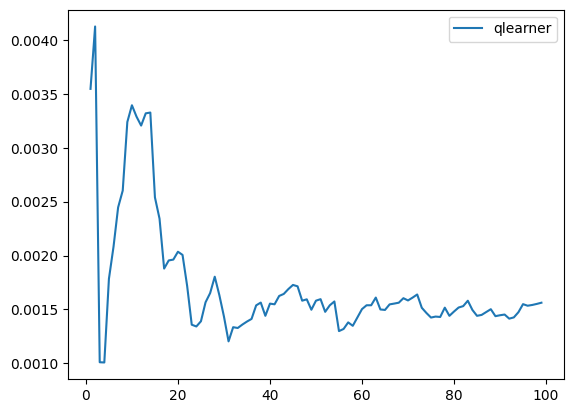

In [39]:
cv_df.plot()

In [40]:
timer.to_csv(pathlinker.prediction / "obp_duration.csv")

In [41]:
cv_df.iloc[range(0, 100, 10), :]

qlearner
0        NaN
10  0.003394
20  0.002035
30  0.001434
40  0.001554
50  0.001581
60  0.001503
70  0.001583
80  0.001480
90  0.001446

In [42]:
tg_flg = output_df["treatment"] == 1
output_df.loc[tg_flg, "conversion"].mean() - output_df.loc[~tg_flg, "conversion"].mean()

0.0015903436605971906